# Umbrella Sampling and WHAM
MENG 25500 project by Henry Bloom and Arnav Brahmasandra.

Check out our [writeup](Writeup/writeup.pdf) for a theoretical and application-based explanation of umbrella samplin and WHAM, which includes the systems analyzed in this notebook. Also, our implementation strictly in 1D can be found [here](umbsampling.ipynb), which tends to achieve slightly better results.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool
from PIL import Image
import io
from typing import List, Callable
from tqdm import tqdm
import random
import os
from scipy.interpolate import UnivariateSpline
import matplotlib.cm as cm

## Defining our Potential Landscape Function

We start with the Muller-Brown potential, which is a two-dimensional potential energy surface that is commonly used to test optimization algorithms. The potential energy surface is given by the following equation:

$$
V(x, y) = \sum_{i=1}^{4} A_i \exp(a_i(x - x_i)^2 + b_i(x - x_i)(y - y_i) + c_i(y - y_i)^2)
$$

where $A_i$, $a_i$, $b_i$, $c_i$, $x_i$, and $y_i$ are constants. The Muller-Brown potential has four local minima and one global minimum. The global minimum is located at $(0.0898, -0.7126)$ and has a potential energy of $-165.0$.

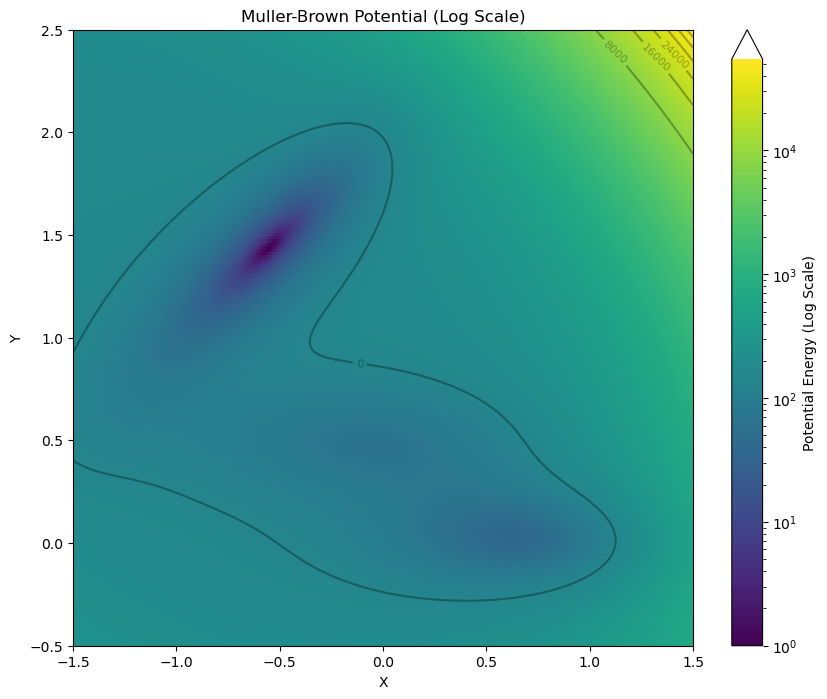

In [2]:
def muller_brown_potential(x, y):
    A = [-200, -100, -170, 15]
    a = [-1, -1, -6.5, 0.7]
    b = [0, 0, 11, 0.6]
    c = [-10, -10, -6.5, 0.7]
    x0 = [1, 0, -0.5, -1]
    y0 = [0, 0.5, 1.5, 1]

    z = 0
    for i in range(4):
        z += A[i] * np.exp(a[i]*(x-x0[i])**2 + b[i]*(x-x0[i])*(y-y0[i]) + c[i]*(y-y0[i])**2)
    return z

def plot_muller_brown_potential_3d(resolution=100, view_angle=(30, 45)):
    x = np.linspace(-2, 2, resolution)
    y = np.linspace(-1, 3, resolution)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(resolution):
        for j in range(resolution):
            Z[i, j] = muller_brown_potential(X[i, j], Y[i, j])

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Potential Energy')
    ax.set_title('Muller-Brown Potential')
    
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    ax.view_init(elev=view_angle[0], azim=view_angle[1])
    
    plt.show()

def plot_muller_brown_potential_2d(resolution=200, show_contours=True):
    """
    Create a 2D contour plot of the Muller-Brown potential with a logarithmic colorbar.
    
    Parameters:
    resolution : int, optional
        Number of points along each axis (default is 200)
    show_contours : bool, optional
        Whether to show contour lines (default is True)
    """
    x = np.linspace(-1.5, 1.5, resolution)
    y = np.linspace(-0.5, 2.5, resolution)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(resolution):
        for j in range(resolution):
            Z[i, j] = muller_brown_potential(X[i, j], Y[i, j])

    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Shift the potential to ensure all values are positive
    Z_shifted = Z - Z.min() + 1  # Add 1 to avoid log(0)
    
    # Optinal: uncomment to cap the values at 700
    # Z_capped = np.minimum(Z_shifted, 700)
    
    # Create a custom colormap with white for values above 700
    cmap = plt.get_cmap('viridis').copy()
    cmap.set_over('white')

    # Use LogNorm for logarithmic scale
    norm = colors.LogNorm()

    im = ax.imshow(Z_shifted, extent=[-1.5, 1.5, -0.5, 2.5], origin='lower', 
                   cmap=cmap, norm=norm, aspect='auto')
    
    # Add contour lines if requested
    if show_contours:
        contours = ax.contour(X, Y, Z, colors='k', alpha=0.3)
        ax.clabel(contours, inline=True, fontsize=8)
    
    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Muller-Brown Potential (Log Scale)')
    
    # Add a color bar
    cbar = fig.colorbar(im, extend='max')
    cbar.set_label('Potential Energy (Log Scale)')
    
    plt.show()

plot_muller_brown_potential_2d(resolution=200, show_contours=True)

In [3]:
def plot_2d_potential(potential_func, x_range, y_range, resolution=200, show_contours=True, 
                      log_scale=True, cmap='viridis', title='2D Potential'):
    """
    Create a 2D contour plot of a given potential function.
    
    Parameters:
    potential_func : callable
        The potential function to plot. Should take two arguments (x, y).
    x_range : tuple
        The range of x values as (min_x, max_x).
    y_range : tuple
        The range of y values as (min_y, max_y).
    resolution : int, optional
        Number of points along each axis (default is 200).
    show_contours : bool, optional
        Whether to show contour lines (default is True).
    log_scale : bool, optional
        Whether to use a logarithmic color scale (default is True).
    cmap : str, optional
        The colormap to use (default is 'viridis').
    title : str, optional
        The title of the plot (default is '2D Potential').
    """
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(y_range[0], y_range[1], resolution)
    X, Y = np.meshgrid(x, y)
    Z = potential_func(X, Y)

    fig, ax = plt.subplots(figsize=(10, 8))
    
    if log_scale:
        # Shift the potential to ensure all values are positive
        Z_shifted = Z - Z.min() + 50  # Add to avoid log(0)
        norm = colors.LogNorm()
    else:
        Z_shifted = Z
        norm = colors.Normalize()

    # Create a custom colormap with white for values above the maximum
    custom_cmap = plt.get_cmap(cmap).copy()
    custom_cmap.set_over('white')

    im = ax.imshow(Z_shifted, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], 
                   origin='lower', cmap=custom_cmap, norm=norm, aspect='auto')
    
    # Add contour lines if requested
    if show_contours:
        contours = ax.contour(X, Y, Z, colors='k', alpha=0.3)
        ax.clabel(contours, inline=True, fontsize=8)
    
    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    
    # Add a color bar
    cbar = fig.colorbar(im, extend='max')
    cbar.set_label('Potential Energy' + (' (shifted log scale)' if log_scale else ''))
    
    plt.show()

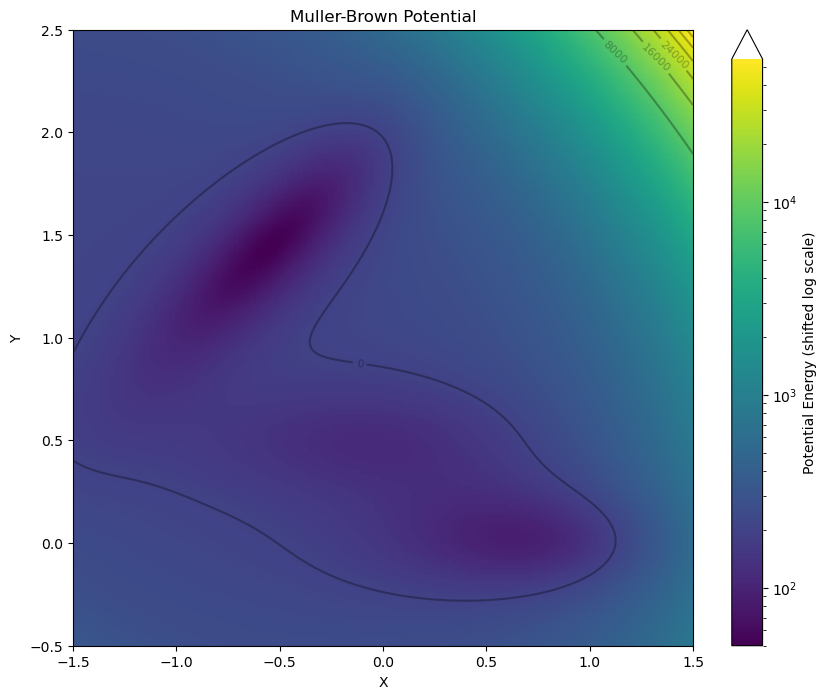

In [4]:
plot_2d_potential(muller_brown_potential, 
                  x_range=(-1.5, 1.5), 
                  y_range=(-0.5, 2.5), 
                  title='Muller-Brown Potential')

## Define the Bias Functions

In [5]:
def create_n_dimensional_windows(dimensions: int, min_values: List[float], max_values: List[float], Nwindows: int) -> tuple:
    """
    Create n-dimensional windows for sampling.

    Args:
    dimensions (int): Number of dimensions
    min_values (List[float]): Minimum values for each dimension
    max_values (List[float]): Maximum values for each dimension
    Nwindows (int): Number of windows per dimension

    Returns:
    tuple: (centers, dx)
    """
    centers = []
    dx = []
    for dim in range(dimensions):
        min_x, max_x = min_values[dim], max_values[dim]
        dx_dim = (max_x - min_x) / Nwindows
        centers_dim = np.linspace(min_x + dx_dim/2, max_x - dx_dim/2, Nwindows)
        centers.append(centers_dim)
        dx.append(dx_dim)
    return np.array(centers), np.array(dx)

class PsiFunction:
    def __init__(self, center: np.ndarray, k: float):
        self.center = center
        self.k = k

    def __call__(self, *args):
        pos = np.stack(args, axis=-1)  # Stack inputs along the last axis
        return 0.5 * self.k * np.sum((pos - self.center)**2, axis=-1)

def create_biases(centers: np.ndarray, k: float) -> np.ndarray:
    """
    Create bias functions for n-dimensional windows and return them as an n-dimensional array.

    Args:
    centers (np.ndarray): Centers of the windows, shape (dimensions, Nwindows)
    k (float): Spring constant for the bias functions

    Returns:
    np.ndarray: n-dimensional array of bias functions, shape ([Nwindows] * dimensions)
    """
    dimensions, Nwindows = centers.shape
    bias_functions = np.empty([Nwindows] * dimensions, dtype=object)  # Create an n-dimensional array

    for i in range(Nwindows**dimensions):
        indices = np.unravel_index(i, [Nwindows] * dimensions)
        center = np.array([centers[d][idx] for d, idx in enumerate(indices)])
        bias_functions[indices] = PsiFunction(center, k)

    return bias_functions

In [6]:
Nwindows = 30 # number of windows to consider in each dimension –– Nwindows^2 bias functions will be made
k = 3000 # spring constant used for each bias function

x_range=(-1.5, 1.5) # range of x values to create bias functions over
y_range=(-0.5, 2.5) # range of y values to create bias functions over

centers = np.zeros((2, Nwindows)) # actual x and y values used as the centers for each bias function
centers[0] = np.linspace(*x_range, Nwindows)
centers[1] = np.linspace(*y_range, Nwindows)

bias_functions = create_biases(centers, k)

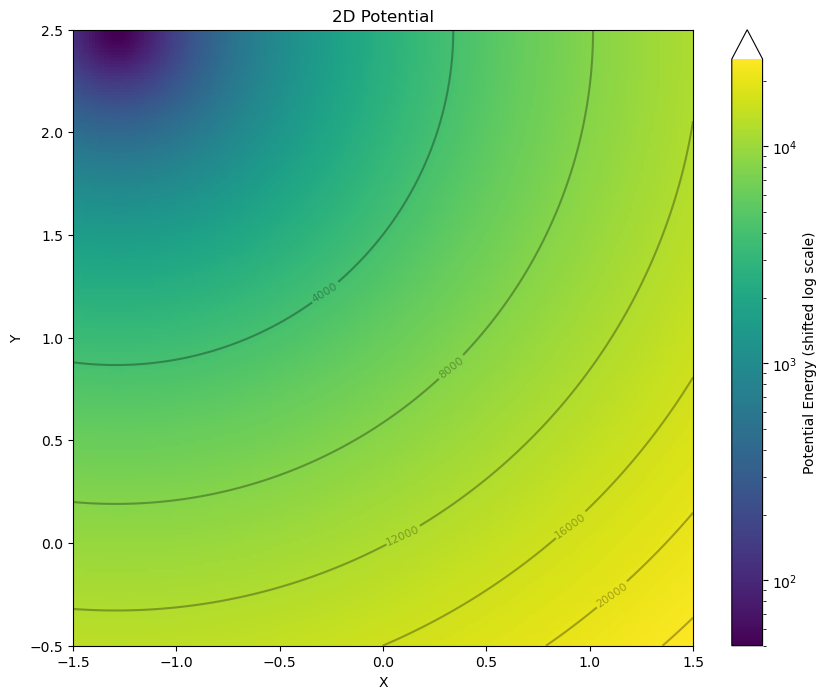

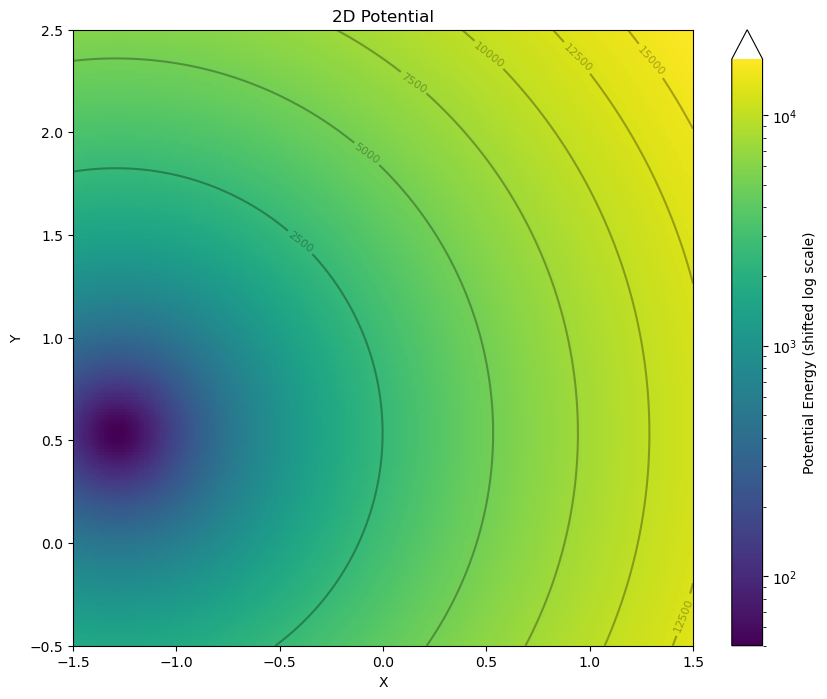

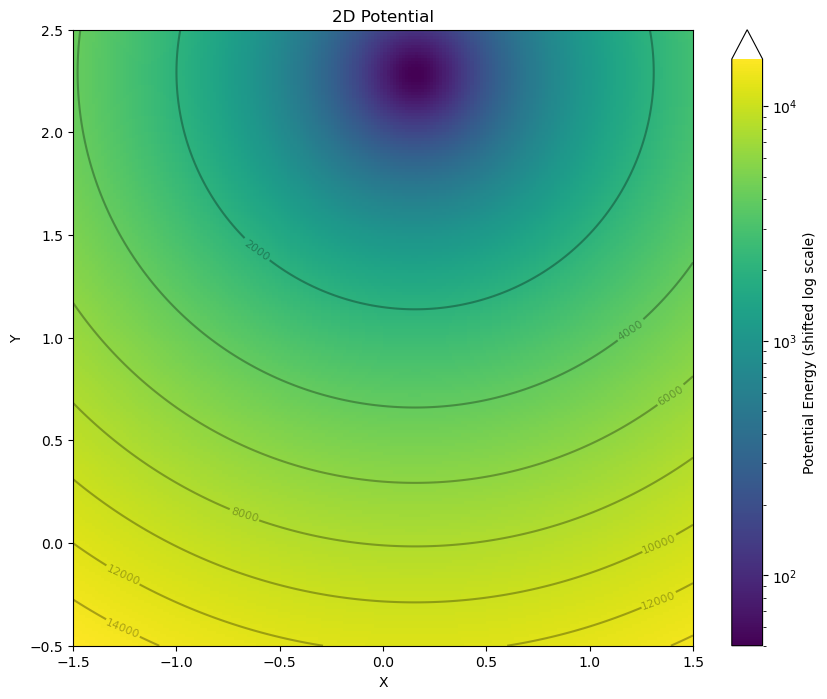

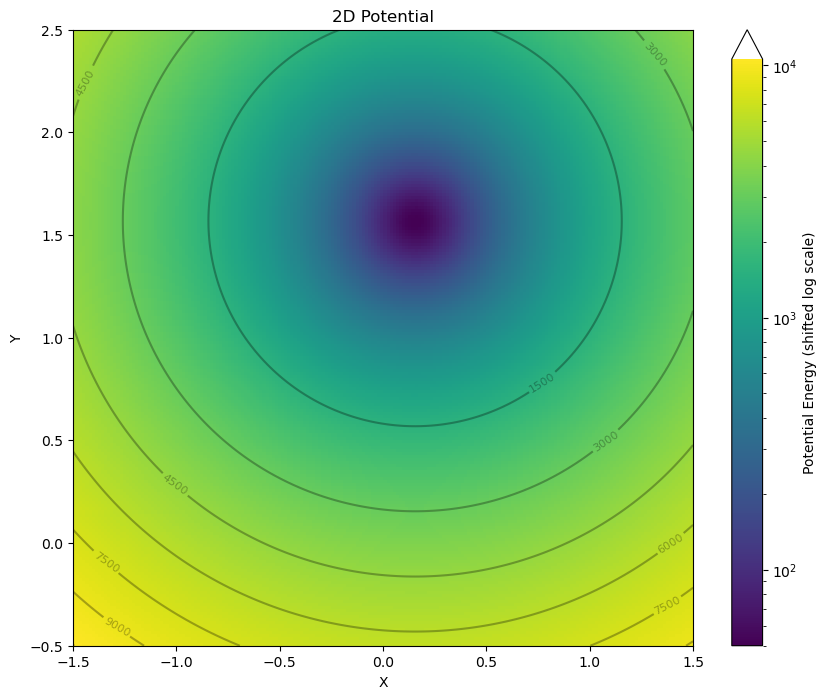

In [7]:
# Visualize four random bias functions
for i in random.sample(range(Nwindows), 2):
    for j in random.sample(range(Nwindows), 2):
        plot_2d_potential(
            bias_functions[i][j],
            x_range,
            y_range,
        )

# Monte Carlo in $n$ Dimensions

In [8]:
def monte_carlo_sampling_per_window(bias: Callable, V: Callable, dimensions: int, minima: List[int], maxima: List[int], nSweeps: int, beta: int, dispSize: int):
    """
    Perform Monte Carlo sampling of the biased distribution for a given window.

    Args:
        bias (callable): The bias function for this window
        V (callable): The landscape function V(x)
        dimensions (int): Number of dimensions
        minima (List[int]): Minimum range to consider in each dimension
        maxima (List[int]): Maximum range to consider in each dimension
        nSweeps (int): Number of iterations to run
        beta (int): Inverse thermal energy
        dispSize (int): Displacement size to consider in each direction

    Returns:
        numpy.ndarray: The samples drawn from the biased distribution.
    """

    samples = np.zeros((nSweeps, dimensions))

    # Pick a random starting point in the window and get potential energy
    current_pos = np.array([np.random.uniform(minima[i], maxima[i]) for i in range(dimensions)])
    
    current_U = V(*current_pos) + bias(*current_pos)

    for sweep in range(nSweeps):
        # Propose a new position
        proposed_pos = current_pos + dispSize * np.random.uniform(-1, 1, dimensions)

        proposed_U = V(*proposed_pos) + bias(*proposed_pos)

        # Acceptance criterion
        delta_U = proposed_U - current_U
        acceptance_prob = min(1, np.exp(-beta * delta_U))

        # Accept or reject
        if np.random.random() < acceptance_prob:
            current_pos = proposed_pos
            current_U = proposed_U

        samples[sweep] = current_pos
    
    return samples

def monte_carlo_sampling(biases: np.ndarray, V: Callable, dimensions: int, minima: List[float], maxima: List[float], 
                         nWindows: int, nSweeps: int, beta: float, dispSize: float) -> np.ndarray:
    """
    Perform Monte Carlo sampling of the biased distribution for all windows in n dimensions.

    Args:
    biases (np.ndarray): An n-dimensional array of bias functions for each window.
    V (Callable): The landscape function V(x).
    dimensions (int): Number of dimensions.
    minima (List[float]): Global minimum range to consider in each dimension.
    maxima (List[float]): Global maximum range to consider in each dimension.
    nWindows (int): Number of windows per dimension.
    nSweeps (int): Number of iterations to run per window.
    beta (float): Inverse thermal energy.
    dispSize (float): Displacement size to consider in each direction.

    Returns:
    numpy.ndarray: The samples drawn from the biased distribution for all windows.
    """
    # Initialize an n-dimensional array to store samples for each window
    all_samples = np.empty([nWindows] * dimensions, dtype=object)

    # Calculate the size of each window in each dimension
    window_sizes = [(maxima[i] - minima[i]) / nWindows for i in range(dimensions)]

    total_iterations = nWindows ** dimensions

    # Iterate over all combinations of windows in n dimensions
    for index in tqdm(np.ndindex(*([nWindows] * dimensions)), total=total_iterations, desc="Monte Carlo Sampling"):
        # Calculate the minima and maxima for this specific window
        window_minima = [minima[d] + index[d] * window_sizes[d] for d in range(dimensions)]
        window_maxima = [min(window_minima[d] + window_sizes[d], maxima[d]) for d in range(dimensions)]

        # Perform Monte Carlo sampling for this window
        window_samples = monte_carlo_sampling_per_window(
            bias=biases[index],  # Access the correct bias function from the n-dimensional array
            V=V,
            dimensions=dimensions,
            minima=window_minima,
            maxima=window_maxima,
            nSweeps=nSweeps,
            beta=beta,
            dispSize=dispSize
        )

        # Store the samples in the corresponding position in the n-dimensional array
        all_samples[index] = window_samples

    return all_samples

In [9]:
T = 298 # K
kB = 1.38064852e-2 # Boltzmann constant (zJ/K)
beta = 1 / (kB * T)
printModulus = 10 # frequency of prints to screen
writeModulus = 10  # frequency of writes to file
dispSize = 0.05 # size of displacement in each dimension
nSweeps = 50_000 # number of MC sweeps
dimensions = 2 # number of dimensions

# Minima and maxima are per-dimension
mimima = [x_range[0], y_range[0]]
maxima = [x_range[1], y_range[1]]

## Simulation Run

In [10]:
# Save simulation results to a file / load from file if it exists
samples_file = '2d_muller_brown_potential_samples.npy'
if os.path.exists(samples_file):
    samples = np.load(samples_file, allow_pickle=True)
else:
    samples = monte_carlo_sampling(bias_functions, muller_brown_potential, dimensions, mimima, maxima, Nwindows, nSweeps, beta, dispSize)
    np.save(samples_file, samples)

Monte Carlo Sampling:  93%|█████████▎| 839/900 [11:11<00:49,  1.24it/s]/var/folders/gf/rqrz_xpd00b34c0v2n9m1q1m0000gn/T/ipykernel_16239/2782900917.py:34: RuntimeWarning: overflow encountered in exp
  acceptance_prob = min(1, np.exp(-beta * delta_U))
Monte Carlo Sampling: 100%|██████████| 900/900 [11:59<00:00,  1.25it/s]


## Visualizations

In [11]:
def plot_2d_sample_distribution(samples, x_range, y_range, resolution=100, title="Sample Distribution"):
    """
    Plot the distribution of samples as a heatmap.

    Args:
    samples (np.ndarray): The array of samples with shape (nSweeps, dimensions).
    x_range (tuple): The range of x values as (min_x, max_x).
    y_range (tuple): The range of y values as (min_y, max_y).
    resolution (int): The resolution of the heatmap grid.
    title (str): Title for the plot.
    """
    # Extract x and y samples
    x_samples = samples[:, 0]
    y_samples = samples[:, 1]

    # Create a 2D histogram
    heatmap, xedges, yedges = np.histogram2d(
        x_samples, y_samples, bins=resolution, range=[x_range, y_range]
    )

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(8, 6))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    im = ax.imshow(heatmap.T, extent=extent, origin='lower', aspect='auto', cmap='viridis')
    
    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.set_label('Sample Density')
    
    # Customize the plot
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    
    plt.show()

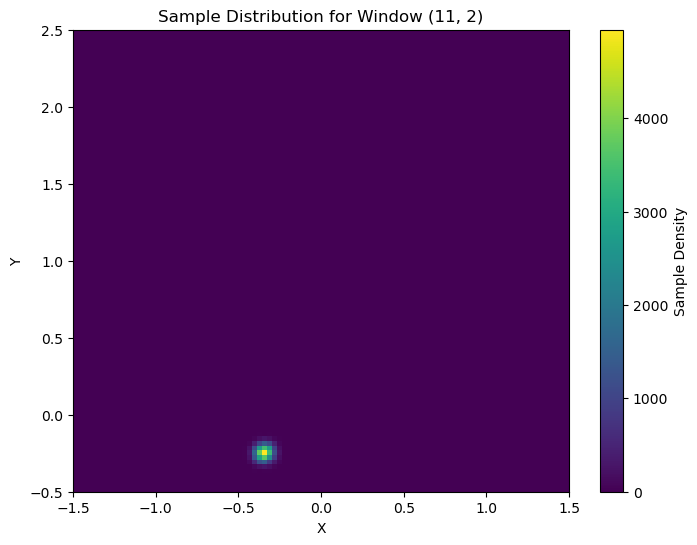

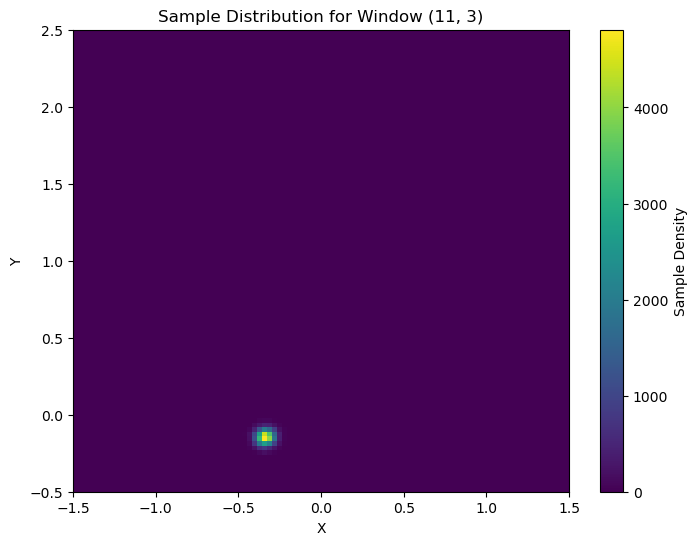

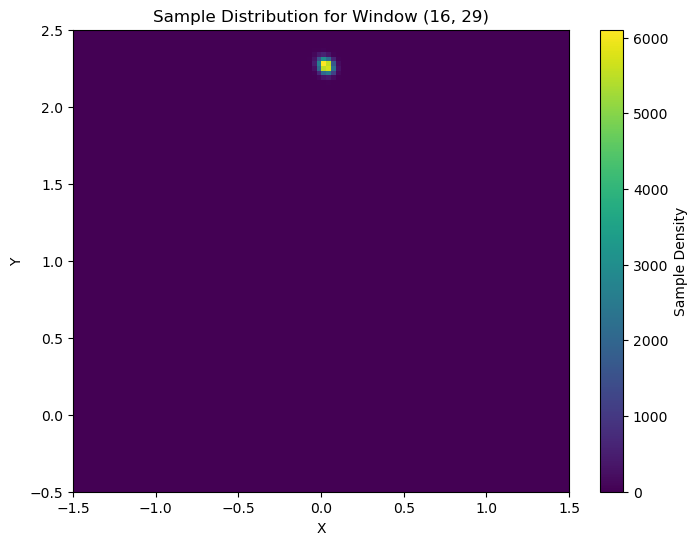

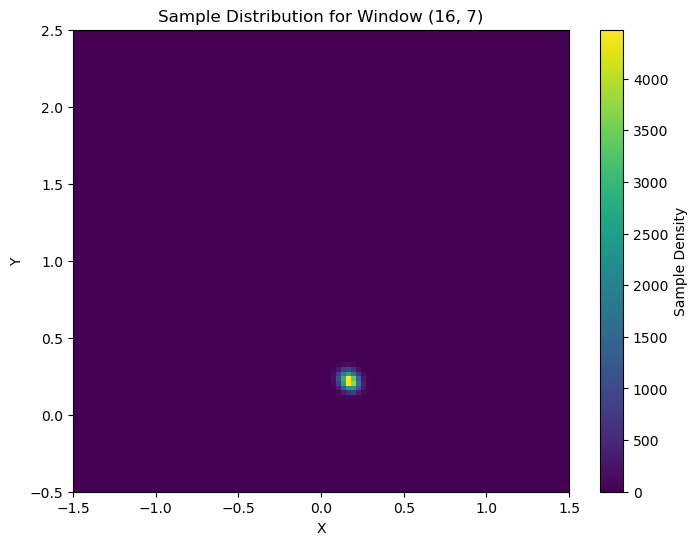

In [12]:
# Visualize four random windows
for i in random.sample(range(Nwindows), 2):
    for j in random.sample(range(Nwindows), 2):
        plot_2d_sample_distribution(
            samples[i][j],
            x_range,
            y_range,
            title=f"Sample Distribution for Window ({i}, {j})"
        )

In [13]:
def create_samples_heatmap_frame(samples, x_range, y_range, resolution=100, title="Sample Distribution", vmin=None, vmax=None):
    """
    Create a heatmap frame for the given samples with standardized color scale.

    Args:
    samples (np.ndarray): The array of samples with shape (nSweeps, dimensions).
    x_range (tuple): The range of x values as (min_x, max_x).
    y_range (tuple): The range of y values as (min_y, max_y).
    resolution (int): The resolution of the heatmap grid.
    title (str): Title for the plot.
    vmin (float): Minimum value for color scale.
    vmax (float): Maximum value for color scale.

    Returns:
    PIL.Image: The heatmap frame as an image.
    """
    x_samples = samples[:, 0]
    y_samples = samples[:, 1]

    heatmap, xedges, yedges = np.histogram2d(
        x_samples, y_samples, bins=resolution, range=[x_range, y_range]
    )

    fig, ax = plt.subplots(figsize=(8, 6))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    im = ax.imshow(heatmap.T, extent=extent, origin='lower', aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
    
    cbar = plt.colorbar(im)
    cbar.set_label('Sample Density')
    
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close(fig)
    
    return Image.open(buf)

# First, calculate the global min and max sample densities
global_min = float('inf')
global_max = float('-inf')
resolution = 100

for index in np.ndindex(*([Nwindows] * dimensions)):
    current_samples = samples[index]
    heatmap, _, _ = np.histogram2d(
        current_samples[:, 0], current_samples[:, 1], 
        bins=resolution, range=[x_range, y_range]
    )
    global_min = min(global_min, heatmap.min())
    global_max = max(global_max, heatmap.max())

# Now create frames with standardized color scale
frames = []

for index in tqdm(np.ndindex(*([Nwindows] * dimensions)), total=Nwindows**dimensions, desc="Creating gif"):
    current_samples = samples[index]
    
    frame = create_samples_heatmap_frame(
        current_samples, 
        x_range, 
        y_range, 
        resolution=resolution, 
        title=f'Sample Distributions',
        vmin=global_min,
        vmax=global_max
    )
    frames.append(frame)

# Save frames as GIF
frames[0].save('sample_distribution_heatmap_animation.gif', 
               save_all=True, 
               append_images=frames[1:], 
               optimize=False, 
               duration=50,  # Duration
               loop=0)

Creating gif: 100%|██████████| 900/900 [00:52<00:00, 17.27it/s]


# WHAM

In [14]:
def plot_2d_probability_distribution(P, bin_centers_grid, x_range, y_range, title="Probability Distribution"):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Extract x and y coordinates from bin_centers_grid
    X, Y = bin_centers_grid
    
    # Plot the heatmap
    im = ax.pcolormesh(X, Y, P, cmap='viridis', shading='auto')
    
    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.set_label('Probability Density')
    
    # Customize the plot
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    
    plt.show()

In [15]:
def WHAM_nD(samples: np.ndarray, biases: np.ndarray, V: Callable, ranges: np.ndarray, beta: float, num_bins: List[int], dimensions: int, max_iters: int = 100, max_atol: float = 1e-6):
    """
    Perform n-dimensional Weighted Histogram Analysis Method (WHAM).

    Args:
    samples (np.ndarray): n-dimensional array of sample arrays, each with shape (nSweeps, dimensions).
    biases (np.ndarray): n-dimensional array of bias functions, each taking n-dimensional input.
    V (Callable): The landscape function V(x).
    ranges (np.ndarray): n-dimensional array of (min, max) tuples to consider for each dimension
    beta (float): Inverse temperature (1/kT).
    num_bins (List[int]): Number of bins for each dimension.
    dimensions (int): Number of dimensions
    max_iters (int): Maximum number of iterations for WHAM.
    max_atol (float): Convergence criterion for free energy differences.

    Returns:
    tuple: (P_history, bin_centers, bin_edges, global_free_energy)
    """
    # Determine ranges for each dimension, if not provided
    if ranges is None:
        ranges = []
        for d in range(dimensions):
            min_val = min(np.min(samples[idx][:, d]) for idx in np.ndindex(samples.shape))
            max_val = max(np.max(samples[idx][:, d]) for idx in np.ndindex(samples.shape))
            ranges.append((min_val, max_val))

    # Create bin edges and centers
    bin_edges = [np.linspace(r[0], r[1], nb+1) for r, nb in zip(ranges, num_bins)]
    bin_centers = [0.5 * (edges[1:] + edges[:-1]) for edges in bin_edges]
    bin_centers_grid = np.meshgrid(*bin_centers, indexing='ij')
    bin_widths = [centers[1] - centers[0] for centers in bin_centers]
    bin_widths_prod = np.prod(bin_widths)

    # Create n-dimensional histograms
    hists = np.empty(samples.shape, dtype=object)
    n_ks = np.zeros(samples.shape)
    P_tilde = np.empty(samples.shape, dtype=object)

    P_shape = None
    for idx in np.ndindex(samples.shape):
        hists[idx], _ = np.histogramdd(samples[idx], bins=bin_edges)
        n_ks[idx] = np.sum(hists[idx])

        P_tilde[idx] = hists[idx] / (bin_widths_prod * n_ks[idx])
        P_shape = P_tilde[idx].shape

    A = np.zeros(samples.shape)
    P = np.zeros(P_shape)
    A_0 = 0

    P_history = []

    for iter in tqdm(range(max_iters), total=max_iters, desc="WHAM Iterations"):
        # Iteratively update P
        numerator = np.zeros(P.shape)
        denominator = np.zeros(P.shape)

        # maybe can speed up by vectorizing
        for idx in np.ndindex(samples.shape):
            numerator += P_tilde[idx] * n_ks[idx] 
            denominator += n_ks[idx] * np.exp(beta * (A[idx] - A_0)) * np.exp(-beta * biases[idx](*bin_centers_grid))
        
        P = numerator / denominator

        # Iteratively update free energies -- maybe can speed up by vectorizing
        for idx in np.ndindex(samples.shape):
            integral = bin_widths_prod * np.sum(P * np.exp(-beta * biases[idx](*bin_centers_grid)))
            A[idx] = - np.log(integral) / beta + A_0

        # Normalize P to provide better numerical stability
        P_AUC = np.sum(P) * bin_widths_prod
        P /= P_AUC
        
        P_history.append(P.copy())
    
    return P_history, bin_centers_grid, bin_edges

## Run WHAM

In [16]:
num_bins = [100, 100] # number of bins for each dimension
num_iters = 100 # number of iterations for WHAM
P_history, bin_centers_grid, bin_edges = WHAM_nD(samples=samples, biases=bias_functions, V=muller_brown_potential, ranges=np.array([x_range, y_range]), beta=beta, num_bins=num_bins, dimensions=2, max_iters=num_iters)

P_history_file = '2d_muller_brown_potential_P_history.npy'
np.save(P_history_file, P_history)

WHAM Iterations: 100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


## Visualization

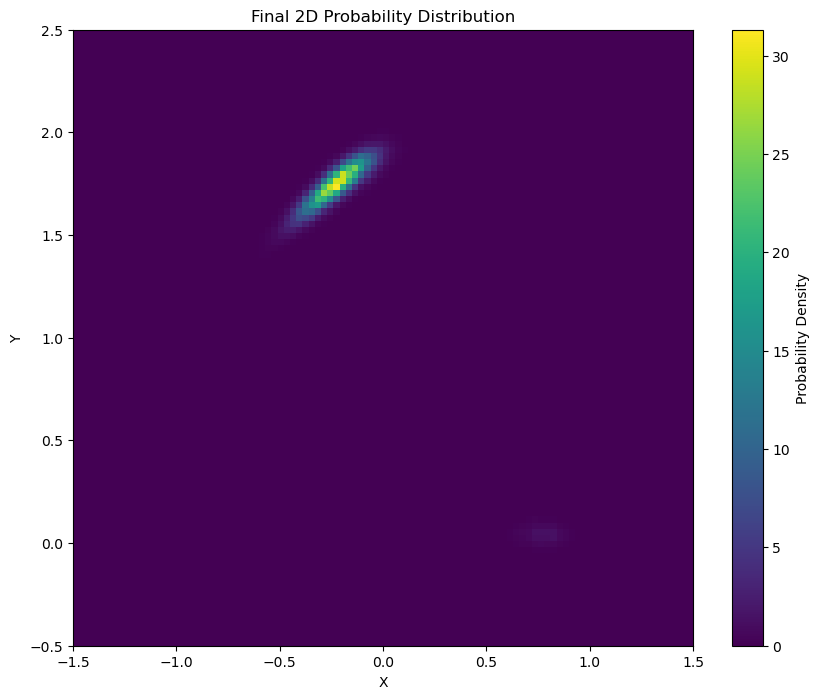

In [17]:
# Extract the final probability distribution (last iteration)
P_final = P_history[-1]

# Define x and y ranges for plotting
x_range = (bin_edges[0][0], bin_edges[0][-1])
y_range = (bin_edges[1][0], bin_edges[1][-1])

# Plot the final 2D probability distribution
plot_2d_probability_distribution(
    P=P_final,
    bin_centers_grid=bin_centers_grid,
    x_range=x_range,
    y_range=y_range,
    title="Final 2D Probability Distribution"
)

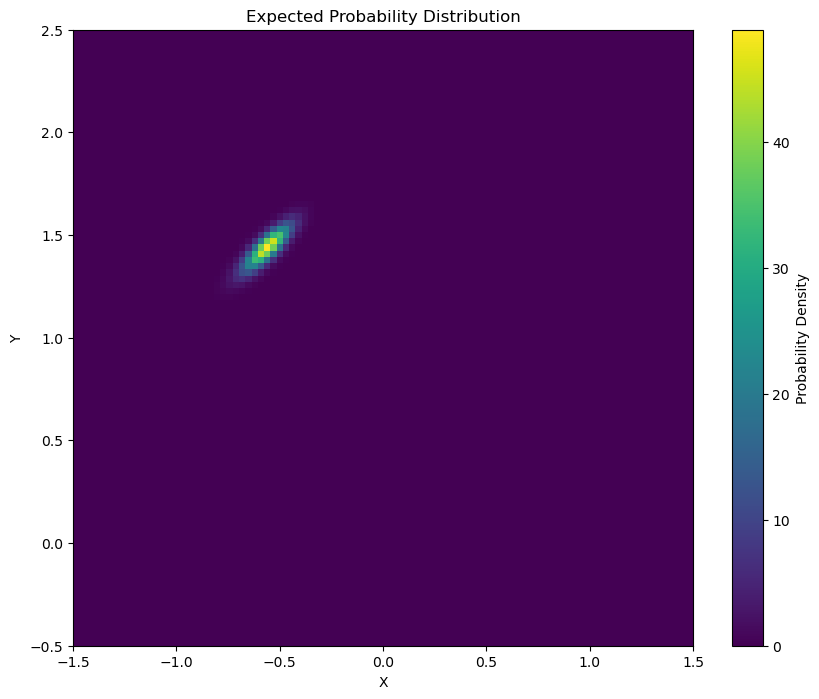

In [18]:
def plot_expected_probability(potential_func, beta, x_range, y_range, num_points=100, title="Expected Probability Distribution"):
    """
    Plot the expected probability distribution based on a given potential function.

    Args:
    potential_func (callable): The potential energy function V(x, y).
    beta (float): Inverse temperature (1/kT).
    x_range (tuple): The range of x values as (min_x, max_x).
    y_range (tuple): The range of y values as (min_y, max_y).
    num_points (int): Number of points to use for each dimension in the plot.
    title (str): Title for the plot.
    """
    # Create a grid of x and y values
    x = np.linspace(x_range[0], x_range[1], num_points)
    y = np.linspace(y_range[0], y_range[1], num_points)
    x_width = x[1]-x[0]
    y_width = y[1]-y[0]

    X, Y = np.meshgrid(x, y)

    # Calculate the potential energy for each point
    Z = potential_func(X, Y)

    # Calculate the probability distribution
    P = np.exp(-beta * Z)

    # Normalize the probability distribution
    P /= np.sum(P) * x_width * y_width

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.pcolormesh(X, Y, P, cmap='viridis', shading='auto')
    
    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.set_label('Probability Density')
    
    # Customize the plot
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    
    plt.show()

plot_expected_probability(muller_brown_potential, beta, x_range, y_range)

# Checking with 1D System
This section validates our multidimensional implementation against our [1D implementation](umbsampling.ipynb).

In [19]:
def two_well_1d(x):
    """
    Defines the landscape function V(x) as described in the image.

    Args:
    x (float or numpy.ndarray): The independent variable.
    epsilon_0 (float): Parameter epsilon_0.
    epsilon_1 (float): Parameter epsilon_1.
    epsilon_2 (float): Parameter epsilon_2.
    sigma (float): Parameter sigma.

    Returns:
    float or numpy.ndarray: The value of the function V(x).
    """

    epsilon_0 = 5
    epsilon_1 = 3
    epsilon_2 = 4
    sigma = 0.6

    term1 = 5 * (x - 1)**8
    term2 = epsilon_0 * np.exp((-epsilon_0 * (x - 0.5)**2) / sigma**2)
    term3 = epsilon_1 * np.exp((-epsilon_1 * (x - 1.0)**2) / sigma**2)
    term4 = epsilon_2 * np.exp((-epsilon_2 * (x - 1.5)**2) / sigma**2)

    return term1 - term2 + term3 - term4

In [20]:
def multi_well_potential(x, base_power=8):
    """
    Defines a multi-well potential function V(x) with adjustable number of wells.

    Args:
    x (float or numpy.ndarray): The independent variable.
    epsilon_values (list): List of epsilon values for each well.
    well_positions (list): List of x-positions for each well.
    sigma (float): Parameter controlling the width of the wells.
    base_power (int): Power for the base polynomial term (default is 8).

    Returns:
    float or numpy.ndarray: The value of the function V(x).
    """
    epsilon_0 = 1.0
    epsilon_1 = 1.5
    epsilon_2 = 2
    sigma = 0.2
    
    well_positions = [0.25, 0.75, 1.5]
    epsilon_values = [epsilon_0, epsilon_1, epsilon_2]
    
    # Base polynomial term
    base_term = 5 * np.min([(x - pos)**base_power for pos in well_positions], axis=0)
    
    # Sum of Gaussian wells
    wells = sum(epsilon * np.exp((-epsilon * (x - pos)**2) / sigma**2) 
                for epsilon, pos in zip(epsilon_values, well_positions))
    
    return base_term - wells

In [21]:
Nwindows = 100
min_x = -0.05
max_x = 2.05
dx = (max_x - min_x) / Nwindows
max_iters = 100

# range of x values
x = np.linspace(min_x, max_x, Nwindows)

centers_1d = np.zeros((1, Nwindows))
centers_1d[0] = np.linspace(min_x + dx/2, max_x - dx/2, Nwindows)

bias_functions_1d = create_biases(centers_1d, k=2000)

In [22]:
one_d_samples = monte_carlo_sampling(bias_functions_1d, two_well_1d, dimensions=1, minima=[min_x], maxima=[max_x], nWindows=Nwindows, nSweeps=100_000, beta=beta, dispSize=dispSize)

Monte Carlo Sampling: 100%|██████████| 100/100 [02:16<00:00,  1.37s/it]


In [ ]:
two_well_x_range = [(0, 2)]
P_history_1d, bin_centers_1d, bin_edges_1d = WHAM_nD(one_d_samples, bias_functions_1d, two_well_1d, ranges=two_well_x_range, beta=beta, num_bins=[100], dimensions=1, max_iters=max_iters)

WHAM Iterations: 100%|██████████| 100/100 [00:00<00:00, 647.89it/s]


In [28]:
multi_well_samples = monte_carlo_sampling(bias_functions_1d, multi_well_potential, dimensions=1, minima=[min_x], maxima=[max_x], nWindows=Nwindows, nSweeps=100000, beta=beta, dispSize=dispSize)

Monte Carlo Sampling: 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


In [29]:
multi_well_x_range = [(0, 2)]
P_history_multi, bin_centers_multi, bin_edges_multi = WHAM_nD(multi_well_samples, bias_functions_1d, multi_well_potential, ranges=multi_well_x_range, beta=beta, num_bins=[100], dimensions=1, max_iters=5000)

WHAM Iterations: 100%|██████████| 5000/5000 [00:07<00:00, 648.23it/s]


/var/folders/gf/rqrz_xpd00b34c0v2n9m1q1m0000gn/T/ipykernel_16239/1828938191.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', max_iters)


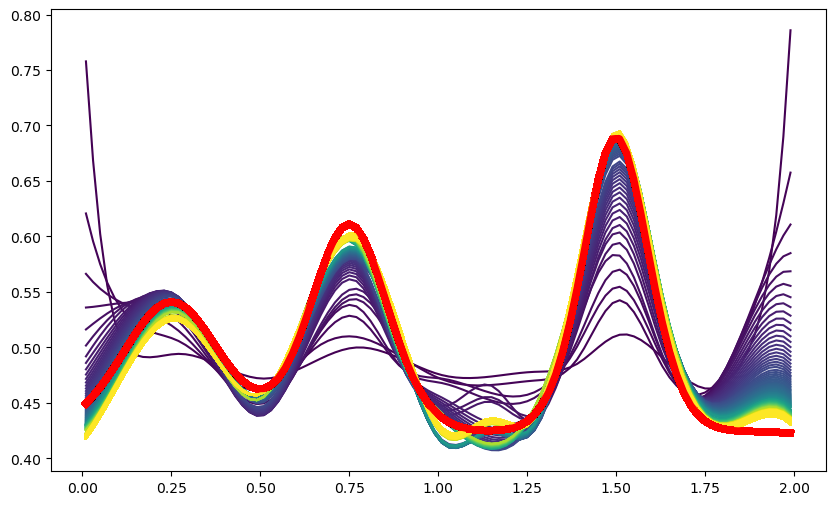

In [30]:
def plot_normalized(P, bin_centers, color, bin_width):
    P_AUC = np.sum(P) * bin_width
    P_normalized = P / P_AUC

    spline = UnivariateSpline(bin_centers, P_normalized, s=0.005)
    P_smooth = spline(bin_centers)

    plt.plot(bin_centers, P_smooth, '-', color=color)


bin_width_multi = bin_centers_multi[0][1] - bin_centers_multi[0][0]


fig, ax = plt.subplots(figsize=(10, 6))
cmap = cm.get_cmap('viridis', max_iters)

for i,P in enumerate(P_history_multi):
    color = cmap(i / max_iters)  # Map iteration to a color in the colormap
    plot_normalized(P, bin_centers_multi[0], color, bin_width_multi)

    recip_V = np.exp(-beta * multi_well_potential(bin_centers_multi[0]))
    bin_width = (bin_centers_multi[0][-1] - bin_centers_multi[0][-2])
    norm_recip_V = recip_V/(np.sum(recip_V) * bin_width)
    plt.plot(bin_centers_multi[0], norm_recip_V, color="red", linewidth=5, label="True")